## Lecture 5. Neural Network
  (1) Fashion MNIST 데이터를 이용하여 softmax classification을 수행한다.\
  (2) 학습데이터에 대한 epoch에 따른 cross-entropy loss와 accuracy 그래프를 그린다.\
  (3) 테스트 데이터에 대한 인식률을 그린다,

Step 0. 설정

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn.functional as F

import random
import numpy as np

In [9]:
L_R = 1e-3
BATCH_SIZE = 100
EPOCHS = 10

In [10]:
if torch.cuda.is_available()==True:
  DEVICE='cuda'
else:
  DEVICE='cpu'
np.random.seed(0b011011)
random.seed(0b011011)
torch.manual_seed(0b011011)
if DEVICE == 'cuda':
  torch.cuda.manual_seed_all(0b011011)


print(DEVICE)

print(np.random.rand(5))
print(np.random.rand(5))
print(random.random())
print(torch.rand(5))

cuda
[0.42572141 0.81458374 0.73539729 0.8680032  0.38338077]
[0.97945663 0.89319435 0.20971517 0.74182765 0.66314332]
0.6484972199788831
tensor([0.9847, 0.0852, 0.5334, 0.2196, 0.2617])


Step 1. Data

In [11]:
train_data = datasets.FashionMNIST(
    root="F:\Python_Codes\Data_for_Practice", 
    train=True, 
    download=True, 
    transform=ToTensor()
    )

test_data= datasets.FashionMNIST(
    root="F:\Python_Codes\Data_for_Practice", 
    train=False, 
    download=True, 
    transform=ToTensor()
    )

In [12]:
train_dataloader =DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader =DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
print('train_data :', train_data)
print('test_data :', test_data)
torch.Tensor.size(train_data.data)

train_data : Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: F:\Python_Codes\Data_for_Practice
    Split: Train
    StandardTransform
Transform: ToTensor()
test_data : Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: F:\Python_Codes\Data_for_Practice
    Split: Test
    StandardTransform
Transform: ToTensor()


torch.Size([60000, 28, 28])

Step 2. Neural Network

In [14]:
class NN(nn.Module):
#nn.Module을 서브클래스로 두면서 NN을 정의하고, __init__에서 NN layers을 초기화한다.
	drop_prob=0.5
	def __init__(self):
	#init에서는 모델을 초기화하고, 모델 구조 정의가 이루어진다.
		super(NN, self).__init__()
		self.net = nn.Sequential(
      nn.Linear(28*28,256),
	  torch.nn.BatchNorm1d(256),
      nn.ReLU(),
	  nn.Dropout(p=NN.drop_prob),
      nn.Linear(256,32),
	  torch.nn.BatchNorm1d(32),
      nn.ReLU(),
	  nn.Dropout(p=NN.drop_prob),
      nn.Linear(32,10)
				)
	
	def forward(self, x):
	#forward에서는 실행 정의가 이루어진다. 즉 NN의 결과를 계산한다.
		return self.net(x)

#init단에서 모델 정의 후 forward단에서 내 맘대로 배치해도 된다.
#파이썬 딥러닝 파이토치 참고.

model=NN().to(DEVICE)

Step 3 and 4. Loss Function and Optimization

In [15]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=L_R)

Train & Step 5. Test

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
  model.train()
  data_num=len(dataloader.dataset)
  batch_num=len(dataloader)
  train_loss=0
  correct=0

  for batchs, (X,Y) in enumerate(train_dataloader):
    optimizer.zero_grad()

    X=X.view(-1,28*28).to(DEVICE)
    Y=Y.to(DEVICE)

    Y_hat=model(X)
    loss=loss_fn(Y_hat, Y)
    loss.backward()
    optimizer.step()

    correct+= (Y_hat.argmax(1) == Y).type(torch.float).sum().item()
    train_loss+=loss.item()

  train_loss/=batch_num
  accuracy = correct/data_num

  print(f"Train - avg Loss= {train_loss:>8f},  Accuracy: {(100*accuracy):>0.1f}%", end = "  ")

  return train_loss, accuracy

  


In [17]:
def test_loop(dataloader, model, loss_fn):
  model.eval()
  data_num=len(dataloader.dataset)
  batch_num=len(dataloader)
  test_loss=0
  correct=0

  with torch.no_grad():
    for batchs, (X,Y) in enumerate(dataloader):
      X=X.view(-1,28*28).to(DEVICE)
      Y=Y.to(DEVICE)

      Y_hat=model(X)
      loss=loss_fn(Y_hat,Y)

      correct+= (Y_hat.argmax(1) == Y).type(torch.float).sum().item()
      test_loss += loss.item()
    
  test_loss/=batch_num
  accuracy = correct/data_num

  print(f"Test - avg Loss= {test_loss:>8f},  Accuracy: {(100*accuracy):>0.1f}%", end = "  ")

  return test_loss, accuracy
   


In [18]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

for epoch in range(EPOCHS):
  print(f"\n{epoch+1}번째 Epoch", end="  ")
  loss, acc = train_loop(train_dataloader, model, loss_fn, optimizer)
  train_loss.append(loss)
  train_acc.append(acc)

  loss_t, acc_t = test_loop(test_dataloader, model, loss_fn)
  test_loss.append(loss_t)
  test_acc.append(acc_t)

print("Done!")



1번째 Epoch  Train - avg Loss= 0.874603,  Accuracy: 73.4%  Test - avg Loss= 0.470480,  Accuracy: 82.9%  
2번째 Epoch  Train - avg Loss= 0.616010,  Accuracy: 79.6%  Test - avg Loss= 0.435827,  Accuracy: 83.8%  
3번째 Epoch  Train - avg Loss= 0.555970,  Accuracy: 81.3%  Test - avg Loss= 0.403922,  Accuracy: 85.5%  
4번째 Epoch  Train - avg Loss= 0.523229,  Accuracy: 82.4%  Test - avg Loss= 0.399227,  Accuracy: 85.6%  
5번째 Epoch  Train - avg Loss= 0.499228,  Accuracy: 83.2%  Test - avg Loss= 0.385157,  Accuracy: 85.8%  
6번째 Epoch  Train - avg Loss= 0.487644,  Accuracy: 83.6%  Test - avg Loss= 0.381747,  Accuracy: 86.2%  
7번째 Epoch  Train - avg Loss= 0.470971,  Accuracy: 84.0%  Test - avg Loss= 0.369188,  Accuracy: 86.4%  
8번째 Epoch  Train - avg Loss= 0.456260,  Accuracy: 84.3%  Test - avg Loss= 0.364515,  Accuracy: 87.1%  
9번째 Epoch  Train - avg Loss= 0.447184,  Accuracy: 84.6%  Test - avg Loss= 0.352185,  Accuracy: 87.3%  
10번째 Epoch  Train - avg Loss= 0.439630,  Accuracy: 85.2%  Test - avg Los

Plot

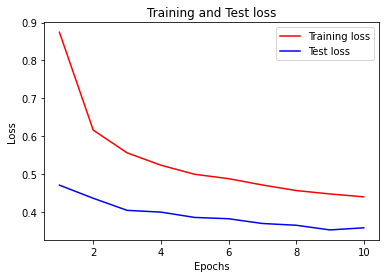

In [19]:
epochs=np.arange(1,EPOCHS+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

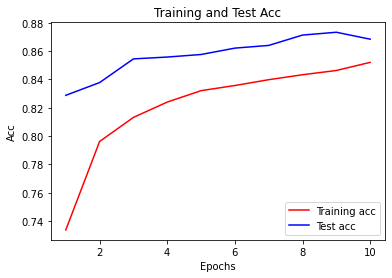

In [20]:
plt.clf()   # 그래프를 초기화합니다
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()